# Support Vector Machine

In [10]:
%pip install -q pandas matplotlib numpy scikit-learn ace_tools panelsplit shap upgrade jupyter ipywidgets 
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install tqdm_joblib
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.4\bin")
import thundersvm
from thundersvm import SVR 
import torch
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import ParameterGrid

import zipfile


from panelsplit.cross_validation import PanelSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

import random
import multiprocessing
from joblib import Parallel, delayed
# Check number of CPU cores
num_cores = multiprocessing.cpu_count()
print("Number of CPU cores available:", num_cores)

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of CPU cores available: 12


In [3]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

In [22]:
#Getting rid of redundant columns
# X final
X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'e_minas_anti', 'total_ac']) 

print(len(X1.columns))
# Keep feature names
original_feature_names = list(X1.columns) 

# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])

# Normalize output
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

70


In [23]:
# Set seed for reproducibility
seed_value = 17
np.random.seed(seed_value)

# Assuming final_df, X1, y, and PanelSplit are defined similarly to your original setup.
# For example, PanelSplit could be a custom cross-validation generator for panel data.
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# To store cross-validation results
cv_results = []

# Global progress bar for cross-validation folds
with tqdm(total=panel_split.n_splits, desc="Processing Folds with ThunderSVM") as pbar:
    for fold, (train_idx, test_idx) in enumerate(panel_split.split(X1)):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X1[train_idx], X1[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Define and train the ThunderSVM SVR model
        # Here we use a basic RBF kernel; you can adjust parameters (C, epsilon, kernel, etc.) as needed.
        svr_model = SVR(kernel="rbf", C=1.0, epsilon=0.1)
        svr_model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = svr_model.predict(X_train)
        y_test_pred = svr_model.predict(X_test)
        
        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)
        
        # Store the metrics for the current fold
        cv_results.append({
            "fold": fold,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2_test": r2_test,
            "R2_train": r2_train
        })
        
        pbar.update(1)

# Output the cross-validation results
# 🔹 Compute Averages Across CV Splits
avg_results = {metric: np.mean([fold[metric] for fold in cv_results]) for metric in cv_results[0].keys()}

# 🔹 Print Results
print(f"✅ XGBoost with PanelSplit Results:")
print(f"📊 Avg MSE: {avg_results['MSE']:.4f}")
print(f"📊 Avg RMSE: {avg_results['RMSE']:.4f}")
print(f"📊 Avg MAE: {avg_results['MAE']:.4f}")
print(f"📊 Avg R² (Train): {avg_results['R2_train']:.4f}")
print(f"📊 Avg R² (Test): {avg_results['R2_test']:.4f}")



Processing Folds with ThunderSVM: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

✅ XGBoost with PanelSplit Results:
📊 Avg MSE: 0.0078
📊 Avg RMSE: 0.0880
📊 Avg MAE: 0.0638
📊 Avg R² (Train): 0.5499
📊 Avg R² (Test): 0.3536


In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import time

# Option: use ThunderSVM if available (it supports GPU acceleration)
try:
    import os
    os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.4\bin")
    import thundersvm
    from thundersvm import SVR as ThunderSVR
    use_gpu = True
except ImportError:
    from sklearn.svm import SVR as ThunderSVR  # fallback to CPU if ThunderSVM is not installed
    use_gpu = False


# Define your parameter grid.
param_grid = {
    "C": [0.1, 1.0, 10.0],
    "epsilon": [0.01, 0.1, 1.0],
    "kernel": ["rbf"]
}

# Total iterations: number of parameter combinations * number of CV folds.
param_list = list(ParameterGrid(param_grid))
n_folds = panel_split.n_splits  # Assuming panel_split is defined.
total_iterations = len(param_list) * n_folds

# Container for results.
results = []

# Initialize tqdm progress bar.
pbar = tqdm(total=total_iterations, desc="Running Grid Search")

# Start time to estimate running time.
start_time = time.time()

for params in param_list:
    fold_metrics = []
    for fold, (train_idx, test_idx) in enumerate(panel_split.split(X1)):
        # Split the data.
        X_train, X_test = X1[train_idx], X1[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize model with current parameters.
        model = ThunderSVR(**params)
        
        # Fit model.
        model.fit(X_train, y_train)
        
        # Make predictions.
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Compute metrics.
        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        fold_metrics.append({
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2_train": r2_train,
            "R2_test": r2_test
        })
        
        # Update progress bar after each fold.
        pbar.update(1)
    
    # Compute average metrics for current parameters.
    avg_metrics = {metric: np.mean([fold[metric] for fold in fold_metrics])
                   for metric in fold_metrics[0].keys()}
    
    results.append({
        "params": params,
        "metrics": avg_metrics
    })
    
    # Optional: Estimate remaining time.
    elapsed = time.time() - start_time
    iterations_done = pbar.n
    avg_time_per_iter = elapsed / iterations_done
    remaining_time = avg_time_per_iter * (total_iterations - iterations_done)
    pbar.set_postfix({"ETA (sec)": int(remaining_time)})

pbar.close()

# Select the best model based on RMSE.
best_model = min(results, key=lambda x: x['metrics']["RMSE"])

# Print summary.
print("✅ Best Overall Parameters:", best_model['params'])
print("📊 Best Overall MSE: {:.4f}".format(best_model['metrics']['MSE']))
print("📊 Best Overall MAE: {:.4f}".format(best_model['metrics']['MAE']))
print("📊 Best Overall RMSE: {:.4f}".format(best_model['metrics']['RMSE']))
print("📊 Best R² (Train): {:.4f}".format(best_model['metrics']['R2_train']))
print("📊 Best R² (Test): {:.4f}".format(best_model['metrics']['R2_test']))

Running Grid Search: 100%|██████████| 45/45 [01:09<00:00,  1.55s/it, ETA (sec)=0] 

✅ Best Overall Parameters: {'C': 1.0, 'epsilon': 0.01, 'kernel': 'rbf'}
📊 Best Overall MSE: 0.0052
📊 Best Overall MAE: 0.0359
📊 Best Overall RMSE: 0.0712
📊 Best R² (Train): 0.6594
📊 Best R² (Test): 0.5803


In [ ]:
import shap
import numpy as np

# --- 1. Fit your best SVM on all of your training data ---
best_params = best_model["params"]
svm = ThunderSVR(**best_params)
svm.fit(X_train, y_train)   # X_train1 and y_train are NumPy arrays

# --- 2. Pick a small “background” for SHAP (for KernelExplainer) ---
#     (you can subsample if X_train1 is large)
bg_idx = np.random.choice(X_train.shape[0], size=100, replace=False)
background = X_train[bg_idx]

# --- 3. Create a SHAP explainer and get values ---
# Option A: unified API (automatically uses KernelExplainer for non‑trees)
explainer = shap.Explainer(svm.predict, background)
shap_values_svm = explainer(X_train)

PermutationExplainer explainer: 12448it [2:13:04,  1.56it/s]                            


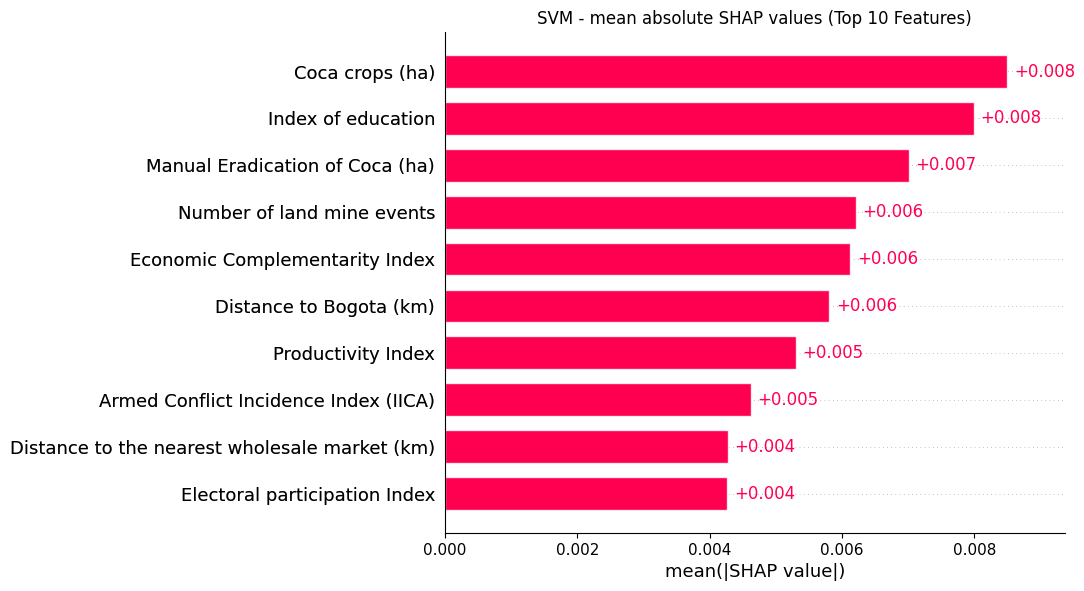

In [ ]:
# Adding correct labels to the variables
rename_dict = {
    # "old_name": "New Descriptive Name"
    "H_coca": "Coca crops (ha)",
    "EIS-03-0":	"Index of education",
    "errad_manual": "Manual Eradication of Coca (ha)",
    "eventos_minas": "Number of land mine events",
    "PCC-03-0": "Economic Complementarity Index",
    "disbogota": "Distance to Bogota (km)",
    "PCC-01-0": "Productivity Index",
    "iica": "Armed Conflict Incidence Index (IICA)",
    "dismdo": "Distance to the nearest wholesale market (km)",
    "GPI-03-0": "Electoral participation Index"
    }

# Compute mean absolute SHAP values for each feature
shap_abs_mean_svm = np.abs(shap_values_svm.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean_svm)[-10:]

# Build custom names for those top 10
custom_feature_names = [
    rename_dict.get(original_feature_names[i], original_feature_names[i])
    for i in top_10_indices
]

# Create the Explanation with renamed features
shap_values_top10_svm = shap.Explanation(
    values=shap_values_svm.values[:, top_10_indices],
    base_values=shap_values_svm.base_values,
    data=shap_values_svm.data[:, top_10_indices],
    feature_names=custom_feature_names
)

# Plot
shap.plots.bar(shap_values_top10_svm, show=False)
plt.title("SVM - mean absolute SHAP values (Top 10 Features)")
plt.show()

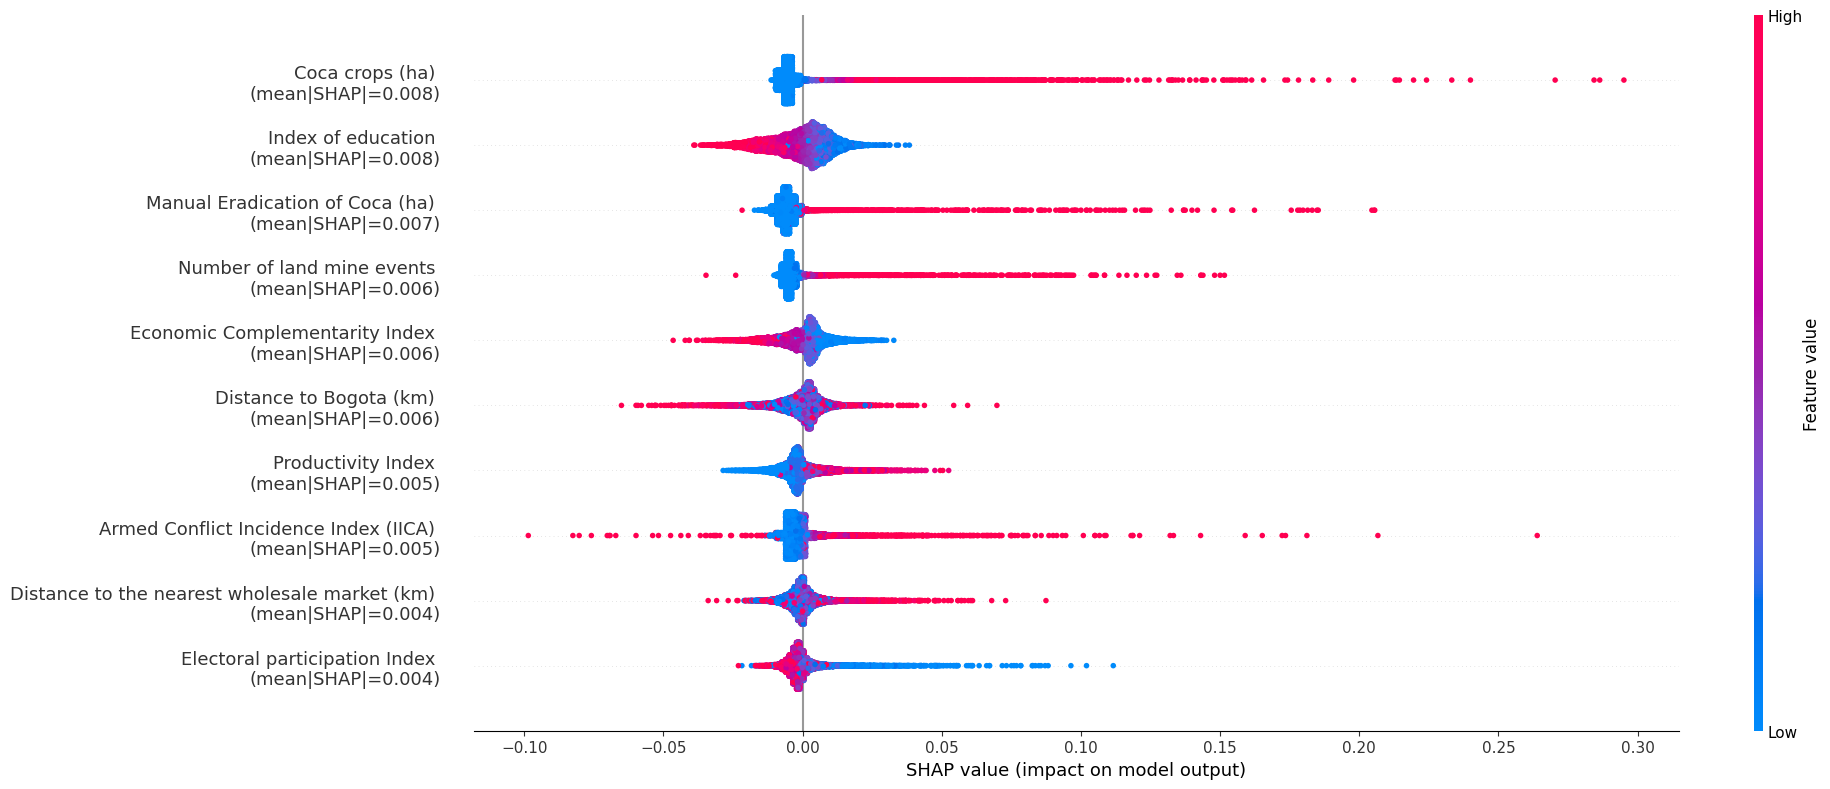

In [ ]:
# 1. Compute mean absolute SHAP values for all features
shap_abs_mean_svm = np.abs(shap_values_svm.values).mean(axis=0)

# 2. Create Series to label features
mean_abs_series = pd.Series(shap_abs_mean_svm, index=original_feature_names)

# 3. Get top 10 features by importance
top10 = mean_abs_series.sort_values(ascending=False).head(10)
top10_indices = [original_feature_names.index(f) for f in top10.index]

# 4. Optional renaming for display
custom_feature_names = [
    f"{rename_dict.get(f, f)} \n(mean|SHAP|={top10[f]:.3f})" for f in top10.index
]

# 5. Slice SHAP Explanation object for top 10 features
shap_values_top10_svm = shap.Explanation(
    values      = shap_values_svm.values[:, top10_indices],
    base_values = shap_values_svm.base_values,
    data        = shap_values_svm.data[:, top10_indices],
    feature_names = custom_feature_names
)

# 7. Plot: SHAP beeswarm plot
shap.plots.beeswarm(shap_values_top10_svm, plot_size=(20, 8), show=False)
plt.title("")
plt.tight_layout()
plt.show()